In [4]:
from deepsensor.data.sources import get_era5_reanalysis_data
from deepsensor.data import DataProcessor 
from matplotlib import pyplot as plt
import xarray as xr
from deepsensor.data import TaskLoader
from deepsensor.train import Trainer, set_gpu_default_device
from deepsensor.model import ConvNP
import deepsensor.torch
import pandas as pd
import torch.optim as optim
from tqdm import tqdm_notebook, tqdm
import numpy as np



In [5]:
# Using the same settings allows use to use pre-downloaded cached data 
data_range=("2010-06-25", "2010-06-30") 
bounding_box_antarctica=(-180, 180, -90, -60) 
bounding_box_n_america = (20, 40, 15, 25)
extent=bounding_box_antarctica
era5_var_IDs=["2m_temperature"] # , "10m_u_component_of_wind", "10m_v_component_of_wind"] 
cache_dir=".datacache"

print('Retrieving ERA5 data...')
era5_raw_ds=get_era5_reanalysis_data(era5_var_IDs, extent =bounding_box_antarctica, date_range=data_range, cache=False, cache_dir=cache_dir)
#print('Done')
#era5_raw_ds.to_netcdf("era5_raw_ds_antarctica.nc", mode='w', format="NETCDF4_CLASSIC", compute=True) 

Retrieving ERA5 data...


/data/hpcdata/users/marrog/conda-env/DeepSens_env/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=27218) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()


In [7]:
cmip_raw_ds = xr.open_dataset("/data/hpcdata/users/marrog/DeepSensor_code/deepsensor_temp/cmip6_raw_ds.nc")
#land_mask_raw_ds = get_gldas_land_mask(extent, cache=True, cache_dir=cache_dir)


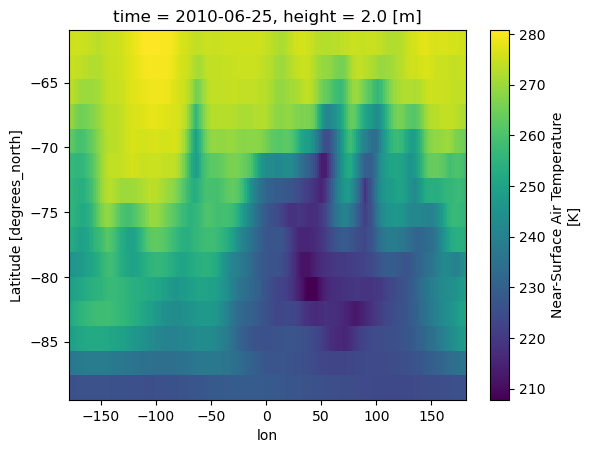

In [8]:
cmip_raw_ds['tas'].isel(time=0).plot.pcolormesh()
plt.show()

In [ ]:
#cmip_raw_ds
cmip_raw_ds_transposed = cmip_raw_ds['tas'].transpose('lat', 'lon', 'time')
era5_raw_ds['2m_temperature']
print(era5_raw_ds['2m_temperature'].dims)
print(era5_raw_ds['2m_temperature'].shape)
print(era5_raw_ds['2m_temperature'].values.shape)
print(era5_raw_ds['2m_temperature'].attrs)
print("era5_raw_ds['2m_temperature'] values:", era5_raw_ds['2m_temperature'].values)

('time', 'lat', 'lon')
(6, 121, 1440)
(6, 121, 1440)
{'long_name': '2 metre temperature', 'short_name': 't2m', 'units': 'K'}
era5_raw_ds['2m_temperature'] values: [[[274.57172 274.53494 274.4671  ... 274.65475 274.63193 274.60764]
  [274.36722 274.31552 274.2247  ... 274.45755 274.43765 274.4163 ]
  [274.12112 274.05228 273.97787 ... 274.2274  274.20383 274.1643 ]
  ...
  [221.56422 221.56847 221.57306 ... 221.55052 221.55505 221.5597 ]
  [221.69084 221.69283 221.69536 ... 221.68402 221.68626 221.68852]
  [222.37695 222.37695 222.37695 ... 222.37695 222.37695 222.37695]]

 [[276.86087 276.84476 276.77173 ... 276.86337 276.87128 276.8768 ]
  [276.74142 276.67642 276.5436  ... 276.78244 276.79117 276.79785]
  [276.47513 276.3621  276.2329  ... 276.6216  276.61404 276.5454 ]
  ...
  [220.76122 220.76416 220.76707 ... 220.75148 220.75488 220.75775]
  [220.38104 220.38261 220.38399 ... 220.37633 220.37761 220.37947]
  [221.11023 221.11023 221.11023 ... 221.11023 221.11023 221.11023]]

 [[27

In [ ]:
cmip_raw_ds.coords['lat'] = cmip_raw_ds.coords['lat'].astype(np.float32)
cmip_raw_ds.coords['lon'] = cmip_raw_ds.coords['lon'].astype(np.float32)
cmip_raw_ds['tas']
print(cmip_raw_ds['tas'].dims)
print(cmip_raw_ds['tas'].shape)
print(cmip_raw_ds['tas'].values.shape)
print(cmip_raw_ds['tas'].attrs)
print("cmip_raw_ds['tas'] values:", cmip_raw_ds['tas'].values)

('time', 'lat', 'lon')
(6, 15, 192)
(6, 15, 192)
{'standard_name': 'air_temperature', 'long_name': 'Near-Surface Air Temperature', 'comment': 'near-surface (usually, 2 meter) air temperature', 'units': 'K', 'cell_methods': 'area: time: mean', 'cell_measures': 'area: areacella', 'history': "2019-11-29T08:38:26Z altered by CMOR: Treated scalar dimension: 'height'. 2019-11-29T08:38:26Z altered by CMOR: Inverted axis: lat."}
cmip_raw_ds['tas'] values: [[[275.40823 275.3616  275.29724 ... 275.54843 275.49023 275.4488 ]
  [274.63055 274.58255 274.4076  ... 274.3589  274.49664 274.6352 ]
  [273.52844 273.14038 272.4156  ... 273.87946 273.89798 273.9165 ]
  ...
  [248.59914 249.08926 249.5794  ... 246.54285 247.32593 248.109  ]
  [236.3389  236.58842 236.83797 ... 235.29497 235.69217 236.08936]
  [225.91618 225.95352 225.99084 ... 225.73503 225.80695 225.87886]]

 [[275.48395 275.22916 275.04163 ... 276.2704  276.01953 275.7617 ]
  [274.7622  274.63147 274.46335 ... 274.90646 274.89978 274.880

In [ ]:
cmip_ds

<xarray.Dataset>
Dimensions:  (time: 6, x1: 15, x2: 192)
Coordinates:
  * time     (time) datetime64[ns] 2010-06-25 2010-06-26 ... 2010-06-30
    height   float64 2.0
  * x1       (x1) float32 0.07438 0.06907 0.06375 ... 0.01058 0.005274 0.0
  * x2       (x2) float32 0.0 0.005236 0.01047 0.01571 ... 0.9895 0.9948 1.0
Data variables:
    tas      (time, x1, x2) float32 1.325 1.323 1.319 ... -0.9907 -0.9887
Attributes: (12/46)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          Spin-up documentation
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    contact:                iitm-esm@tropmet.res.in
    ...                     ...
    title:                  IITM-ESM output prepared for CMIP6
    variable_id:            tas
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by CCCR-IITM is license...
    cmor_version:           3.5.0
    tracking_id:            hdl:21.14100/5d4bf64e-3878-4806-a45b-bc9c6e77a634

In [ ]:
era5_ds

<xarray.Dataset>
Dimensions:         (time: 6, x1: 121, x2: 1440)
Coordinates:
  * time            (time) datetime64[ns] 2010-06-25 2010-06-26 ... 2010-06-30
  * x1              (x1) float32 0.08339 0.0827 0.082 ... 0.00139 0.0006949 0.0
  * x2              (x2) float32 0.0 0.0006949 0.00139 ... 0.9986 0.9993 1.0
Data variables:
    2m_temperature  (time, x1, x2) float32 1.725 1.723 1.72 ... -1.614 -1.614

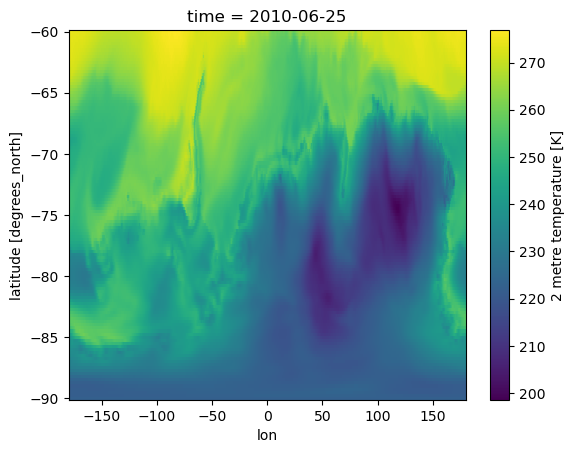

In [9]:
era5_raw_ds["2m_temperature"].isel(time=0).plot.pcolormesh()
plt.show()

/data/hpcdata/users/marrog/DeepSensor_code/deepsensor_temp/deepsensor/data/processor.py:130: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  f"x1_map={x1_map} and x2_map={x2_map} have different ranges ({float(np.diff(x1_map))} "
/data/hpcdata/users/marrog/DeepSensor_code/deepsensor_temp/deepsensor/data/processor.py:131: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  f"and {float(np.diff(x2_map))}, respectively). "
/data/hpcdata/users/marrog/DeepSensor_code/deepsensor_temp/deepsensor/data/processor.py:129: UserWarning: x1_map=(-88.54194641113281, 269.58306884765625) and x2_map=(-178.125, 180.0) have different ranges (358.12501525878906 and 35

DataProcessor with normalisation params:
{'coords': {'time': {'name': 'time'},
            'x1': {'map': (-88.54194641113281, 269.58306884765625),
                   'name': 'lat'},
            'x2': {'map': (-178.125, 180.0), 'name': 'lon'}},
 'tas': {'method': 'mean_std',
         'params': {'mean': 248.05636596679688, 'std': 20.646635055541992}}}


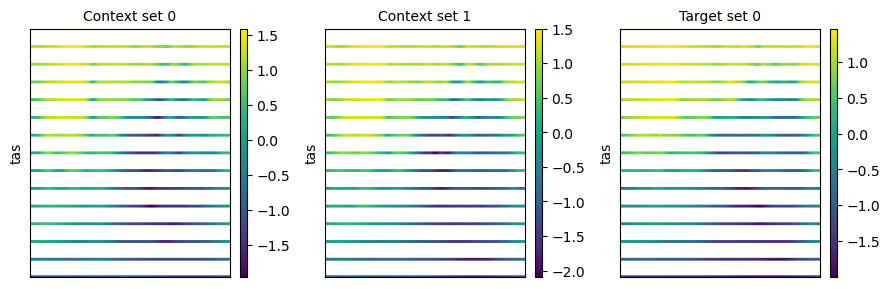

In [ ]:
# Debug to remove
data_processor2=DataProcessor(x1_name="lat", x2_name="lon")
#print(data_processor)
cmip_ds =data_processor2(cmip_raw_ds)
print(data_processor2)

task_loader2 = TaskLoader(
    context=[cmip_ds]*2,
    target=[cmip_ds],
    context_delta_t=[-1, 0],
    target_delta_t=1,
    #links = [(1, 0)]
)

task2 = task_loader2("2010-06-26", context_sampling="all", target_sampling = "all")
deepsensor.plot.task(task2, task_loader2)
plt.show()

In [ ]:
data_processor=DataProcessor(x1_name="lat", x2_name="lon")
#print(data_processor)
era5_ds, cmip_ds =data_processor([era5_raw_ds, cmip_raw_ds])
print(data_processor)

DataProcessor with normalisation params:
{'2m_temperature': {'method': 'mean_std',
                    'params': {'mean': 241.01321411132812,
                               'std': 19.45113182067871}},
 'coords': {'time': {'name': 'time'},
            'x1': {'map': (-90.0, 269.75), 'name': 'lat'},
            'x2': {'map': (-180.0, 179.75), 'name': 'lon'}},
 'tas': {'method': 'mean_std',
         'params': {'mean': 248.05636596679688, 'std': 20.646635055541992}}}


In [ ]:
task_loader = TaskLoader(
    context=[era5_ds, cmip_ds]*2,
    target=[era5_ds],
    context_delta_t=[-1, -1, 0, 0],
    target_delta_t=1,
    #links = [(1, 0)]
)


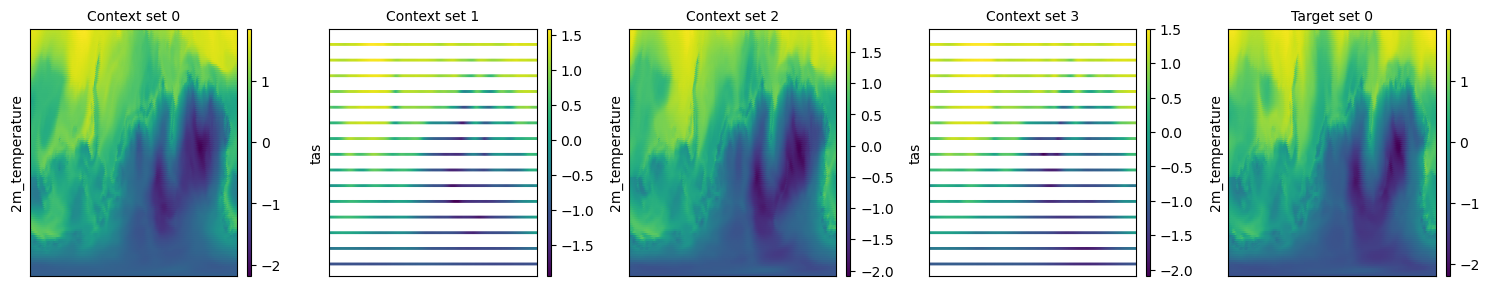

In [ ]:
task = task_loader("2010-06-26", context_sampling="all", target_sampling = "all")
deepsensor.plot.task(task, task_loader)
plt.show()

In [ ]:
model = ConvNP(data_processor, task_loader)
opt = optim.Adam(model.model.parameters(), lr=5e-5)


dim_yc inferred from TaskLoader: (1, 1, 1, 1)
dim_yt inferred from TaskLoader: 1
dim_aux_t inferred from TaskLoader: 0
internal_density inferred from TaskLoader: 1439
encoder_scales inferred from TaskLoader: [0.00034746347228065133, 0.002605976304039359, 0.00034746347228065133, 0.002605976304039359]
decoder_scale inferred from TaskLoader: 0.0006949270326615705


In [ ]:
train_tasks = []
for date in pd.date_range("2010-06-26", "2010-06-28"):
    task = task_loader(date, context_sampling="all", target_sampling = "all")
    train_tasks.append(task)

In [ ]:
print(train_tasks[0])

time: 2010-06-26 00:00:00
ops: []
X_c: [((1, 121), (1, 1440)), ((1, 15), (1, 192)), ((1, 121), (1, 1440)), ((1, 15), (1, 192))]
Y_c: [(1, 121, 1440), (1, 15, 192), (1, 121, 1440), (1, 15, 192)]
X_t: [((1, 121), (1, 1440))]
Y_t: [(1, 121, 1440)]



In [ ]:
# Train model
trainer = Trainer(model, lr=5e-5)
for epoch in tqdm(range(2)):
    batch_losses = trainer(train_tasks)

100%|██████████| 2/2 [00:24<00:00, 12.06s/it]


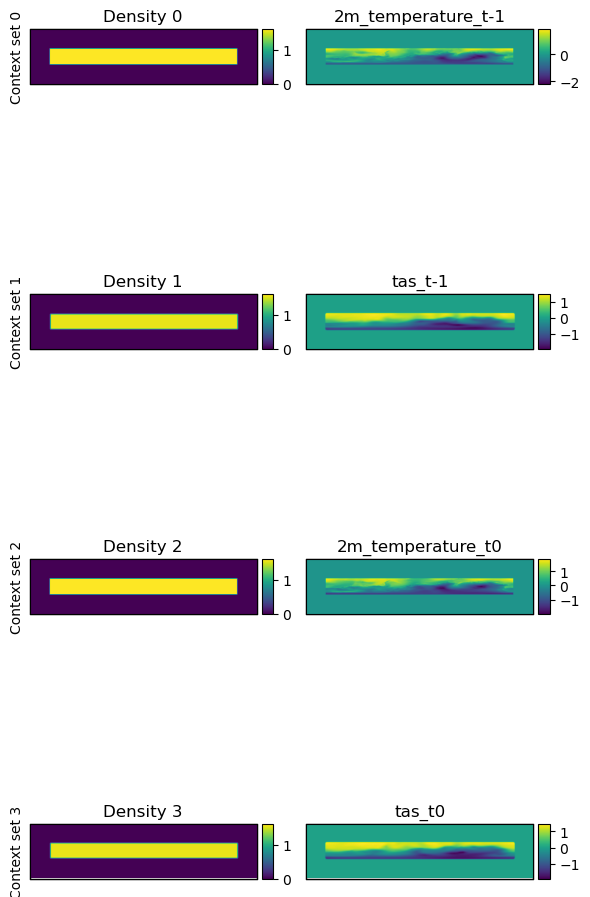

In [ ]:
fig = deepsensor.plot.context_encoding(model, task, task_loader)


In [ ]:
test_task = task_loader("2010-06-29", context_sampling=["all", "all", "all", "all"], target_sampling="all")
predictions = model.predict(test_task, X_t= era5_raw_ds)

/data/hpcdata/users/marrog/DeepSensor_code/deepsensor_temp/deepsensor/model/model.py:388: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  X_t = X_t.isel(time=0).drop("time")


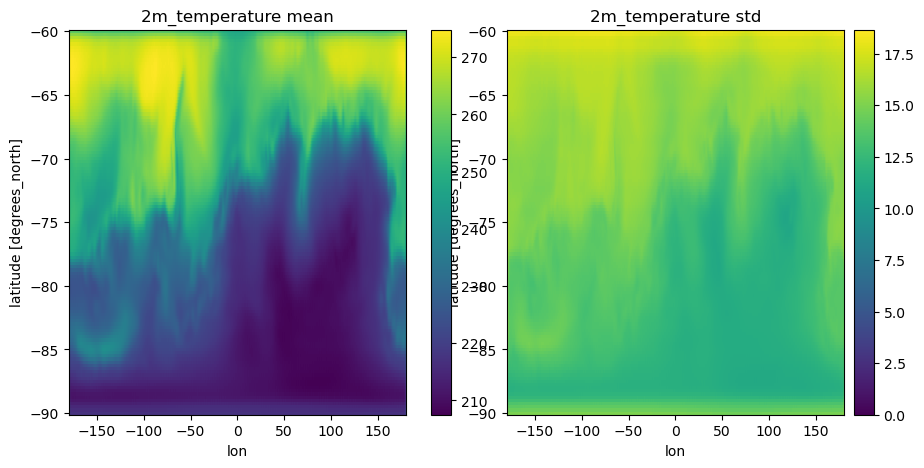

In [ ]:
date = "2010-06-29"
fig = deepsensor.plot.prediction(predictions, date)